In [1]:
import matplotlib.pyplot as plt
import numpy as np
import seaborn as sns
import torch
from torch import nn, optim
import torch.nn.functional as F
from torch.utils.data import Dataset, DataLoader, random_split
from torchvision import datasets
from torchvision.transforms import v2
from torchvision.utils import make_grid

In [2]:
from PIL import ImageFile
ImageFile.LOAD_TRUNCATED_IMAGES = True

In [3]:
device = 'cuda' if torch.cuda.is_available() else 'cpu' # вычисления на графическом процессоре, если возможно
device

'cuda'

In [4]:
train_transform = v2.Compose([v2.Resize([224,224]),v2.ToImage(), v2.ToDtype(torch.float32, scale=True)])
transform = v2.Compose([v2.Resize([224,224]), v2.ToImage(), v2.ToDtype(torch.float32, scale=True)])

In [39]:
trainset = datasets.CIFAR10(root='./data', train=True, download=True, transform=transform)
testset = datasets.CIFAR10(root='./data', train=False, download=True, transform=transform)

Files already downloaded and verified
Files already downloaded and verified


In [40]:
batch_size = 128
data_classses = trainset.classes
num_cls = len(trainset.classes)

In [41]:
# m=int(0.8*len(trainset))
# n=len(trainset)
# trainset, _ = random_split(trainset, lengths=[m, n-m])
train_loader = torch.utils.data.DataLoader(trainset, batch_size=batch_size, shuffle=True, num_workers=2, pin_memory=True)


# m1=int(0.6*len(testset))
# n1=len(testset)
# testset, _ = random_split(testset, lengths=[m1,n1-m1])
test_loader = torch.utils.data.DataLoader(testset, batch_size=batch_size, shuffle=False, num_workers=2, pin_memory=True)

In [42]:
def show_batch(data_loader):
    for images, labels in data_loader:
        fig, ax = plt.subplots(figsize=(15, 15))
        ax.set_xticks([]); ax.set_yticks([])
        ax.imshow(make_grid(images[:32], nrow=8).permute(1, 2, 0).clamp(0,1))
        print(images.shape)
        break

torch.Size([128, 3, 224, 224])


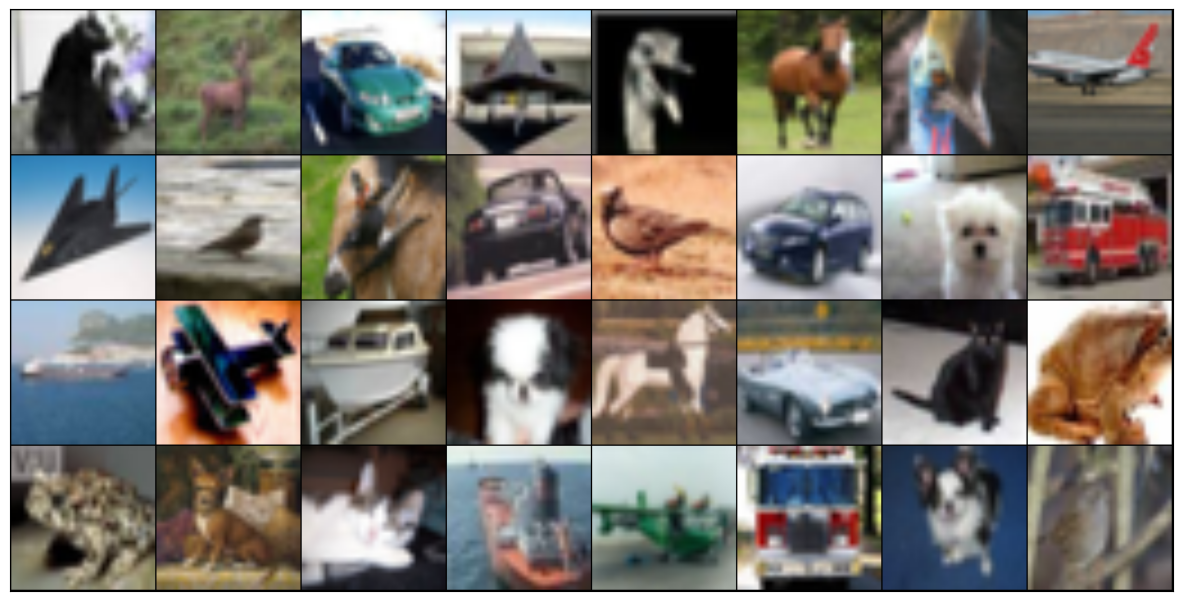

In [43]:
show_batch(train_loader);

torch.Size([128, 3, 224, 224])


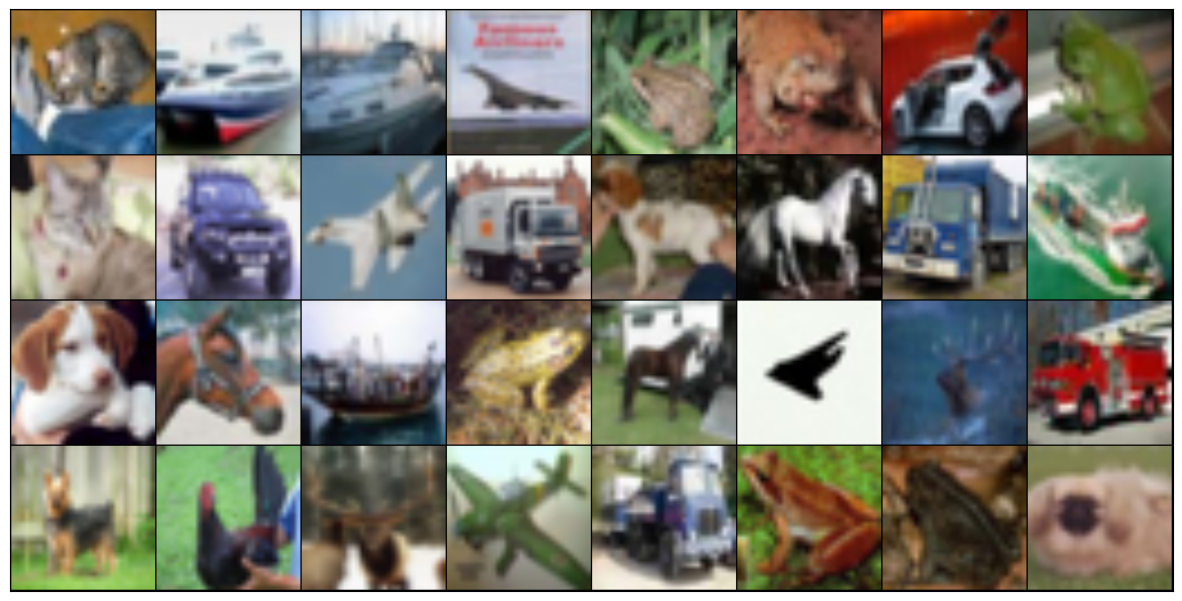

In [44]:
show_batch(test_loader)

In [45]:
import torchvision.models as models

In [46]:
model = models.googlenet(weights='IMAGENET1K_V1')
model.to(device);

In [47]:
! pip install torchinfo

In [48]:
from torchinfo import summary
summary(model,input_size=(1,3,224,224))

Layer (type:depth-idx)                   Output Shape              Param #
GoogLeNet                                [1, 1000]                 --
├─BasicConv2d: 1-1                       [1, 64, 112, 112]         --
│    └─Conv2d: 2-1                       [1, 64, 112, 112]         9,408
│    └─BatchNorm2d: 2-2                  [1, 64, 112, 112]         128
├─MaxPool2d: 1-2                         [1, 64, 56, 56]           --
├─BasicConv2d: 1-3                       [1, 64, 56, 56]           --
│    └─Conv2d: 2-3                       [1, 64, 56, 56]           4,096
│    └─BatchNorm2d: 2-4                  [1, 64, 56, 56]           128
├─BasicConv2d: 1-4                       [1, 192, 56, 56]          --
│    └─Conv2d: 2-5                       [1, 192, 56, 56]          110,592
│    └─BatchNorm2d: 2-6                  [1, 192, 56, 56]          384
├─MaxPool2d: 1-5                         [1, 192, 28, 28]          --
├─Inception: 1-6                         [1, 256, 28, 28]          --
│

In [49]:
model.fc = nn.Linear(1024,num_cls)

In [50]:
model.to(device);

In [51]:
summary(model,input_size=(1,3,224,224))

Layer (type:depth-idx)                   Output Shape              Param #
GoogLeNet                                [1, 10]                   --
├─BasicConv2d: 1-1                       [1, 64, 112, 112]         --
│    └─Conv2d: 2-1                       [1, 64, 112, 112]         9,408
│    └─BatchNorm2d: 2-2                  [1, 64, 112, 112]         128
├─MaxPool2d: 1-2                         [1, 64, 56, 56]           --
├─BasicConv2d: 1-3                       [1, 64, 56, 56]           --
│    └─Conv2d: 2-3                       [1, 64, 56, 56]           4,096
│    └─BatchNorm2d: 2-4                  [1, 64, 56, 56]           128
├─BasicConv2d: 1-4                       [1, 192, 56, 56]          --
│    └─Conv2d: 2-5                       [1, 192, 56, 56]          110,592
│    └─BatchNorm2d: 2-6                  [1, 192, 56, 56]          384
├─MaxPool2d: 1-5                         [1, 192, 28, 28]          --
├─Inception: 1-6                         [1, 256, 28, 28]          --
│

In [52]:
optimizer = optim.AdamW(model.parameters())
criterion = nn.CrossEntropyLoss()

In [53]:
!pip install pytorch-ignite --quiet

In [54]:
from ignite.engine import Events, create_supervised_trainer, create_supervised_evaluator
from ignite.metrics import Accuracy, Loss, RunningAverage, ConfusionMatrix
from ignite.handlers import ModelCheckpoint, EarlyStopping
from ignite.contrib.handlers import ProgressBar, HandlersTimeProfiler
from ignite.handlers import Checkpoint, global_step_from_engine

In [55]:
trainer = create_supervised_trainer(model, optimizer, criterion, device=device)

In [56]:
metrics = { "loss" : Loss(criterion),
           "accuracy" : Accuracy(),
            "cm": ConfusionMatrix(num_classes=10)}

In [57]:
train_evaluator = create_supervised_evaluator(model, metrics = metrics, device = device)
test_evaluator = create_supervised_evaluator(model, metrics = metrics, device = device)

In [58]:
training_history = {'accuracy':[],'loss':[]}
test_history = {'accuracy':[],'loss':[]}
last_epoch = []

In [59]:
@trainer.on(Events.EPOCH_COMPLETED)
def log_training_results(trainer):
    train_evaluator.run(train_loader)
    metrics = train_evaluator.state.metrics
    accuracy = metrics['accuracy']*100
    loss = metrics['loss']
    last_epoch.append(0)
    training_history['accuracy'].append(accuracy)
    training_history['loss'].append(loss)
    print("Результат обучения - Эпоха: {}  Сред. точность: {:.2f} Сред. ошибка: {:.5f}"
          .format(trainer.state.epoch, accuracy, loss))

In [60]:
@trainer.on(Events.EPOCH_COMPLETED)
def log_test_results(trainer):
    test_evaluator.run(test_loader)
    metrics = test_evaluator.state.metrics
    accuracy = metrics['accuracy']*100
    loss = metrics['loss']
    test_history['accuracy'].append(accuracy)
    test_history['loss'].append(loss)
    print("Результат валидации - Эпоха: {}  Сред. точность: {:.2f} Сред. ошибка: {:.5f}"
          .format(trainer.state.epoch, accuracy, loss))

In [61]:
breaker = EarlyStopping(patience = 10, score_function = lambda engine : engine.state.metrics['accuracy'],
                        trainer = trainer)
test_evaluator.add_event_handler(Events.COMPLETED, breaker);

In [62]:
to_save = {'model': model}
saver = Checkpoint(
    to_save, './models',
    n_saved=1, filename_prefix='best',
    score_name="accuracy",
    global_step_transform=global_step_from_engine(trainer),
)
test_evaluator.add_event_handler(Events.COMPLETED, saver);

In [63]:
from tqdm.notebook import tqdm
profiler = HandlersTimeProfiler()
profiler.attach(trainer)
pbar = ProgressBar(persist=True,
    bar_format = '')
pbar.attach(trainer, output_transform = lambda x : {"loss" : x})

In [64]:
@trainer.on(Events.COMPLETED)
def log_confusion_matrix(trainer):
    test_evaluator.run(test_loader)
    metrics = test_evaluator.state.metrics
    cm = metrics['cm']
    cm = cm.numpy()
    cm = cm.astype(int)
    classes = data_classses
    fig, ax = plt.subplots(figsize=(10,10))
    ax= plt.subplot()
    sns.heatmap(cm, annot=True, ax = ax,fmt="d")
    # labels, title and ticks
    ax.set_xlabel('Predicted labels')
    ax.set_ylabel('True labels')
    ax.set_title('Confusion Matrix')
    ax.xaxis.set_ticklabels(classes,rotation=90)
    ax.yaxis.set_ticklabels(classes,rotation=0)

  0%|          | 1/391 [00:00<?, ?it/s]

Результат обучения - Эпоха: 1  Сред. точность: 92.59 Сред. ошибка: 0.22398
Результат валидации - Эпоха: 1  Сред. точность: 89.24 Сред. ошибка: 0.30738


  0%|          | 1/391 [00:00<?, ?it/s]

Результат обучения - Эпоха: 2  Сред. точность: 93.95 Сред. ошибка: 0.17824
Результат валидации - Эпоха: 2  Сред. точность: 90.34 Сред. ошибка: 0.29119


  0%|          | 1/391 [00:00<?, ?it/s]

Результат обучения - Эпоха: 3  Сред. точность: 95.63 Сред. ошибка: 0.12879
Результат валидации - Эпоха: 3  Сред. точность: 90.71 Сред. ошибка: 0.27379


  0%|          | 1/391 [00:00<?, ?it/s]

Результат обучения - Эпоха: 4  Сред. точность: 94.04 Сред. ошибка: 0.17034
Результат валидации - Эпоха: 4  Сред. точность: 89.19 Сред. ошибка: 0.34015


  0%|          | 1/391 [00:00<?, ?it/s]

Результат обучения - Эпоха: 5  Сред. точность: 96.93 Сред. ошибка: 0.08841
Результат валидации - Эпоха: 5  Сред. точность: 91.46 Сред. ошибка: 0.26359


  0%|          | 1/391 [00:00<?, ?it/s]

Результат обучения - Эпоха: 6  Сред. точность: 97.42 Сред. ошибка: 0.07642
Результат валидации - Эпоха: 6  Сред. точность: 91.51 Сред. ошибка: 0.26830


  0%|          | 1/391 [00:00<?, ?it/s]

Результат обучения - Эпоха: 7  Сред. точность: 98.03 Сред. ошибка: 0.05717
Результат валидации - Эпоха: 7  Сред. точность: 92.14 Сред. ошибка: 0.26022


  0%|          | 1/391 [00:00<?, ?it/s]

Результат обучения - Эпоха: 8  Сред. точность: 96.04 Сред. ошибка: 0.11572
Результат валидации - Эпоха: 8  Сред. точность: 90.13 Сред. ошибка: 0.37283


  0%|          | 1/391 [00:00<?, ?it/s]

Результат обучения - Эпоха: 9  Сред. точность: 96.42 Сред. ошибка: 0.10374
Результат валидации - Эпоха: 9  Сред. точность: 89.80 Сред. ошибка: 0.37101


  0%|          | 1/391 [00:00<?, ?it/s]

Результат обучения - Эпоха: 10  Сред. точность: 96.72 Сред. ошибка: 0.09826
Результат валидации - Эпоха: 10  Сред. точность: 90.18 Сред. ошибка: 0.36720


  0%|          | 1/391 [00:00<?, ?it/s]

Результат обучения - Эпоха: 11  Сред. точность: 98.57 Сред. ошибка: 0.04204
Результат валидации - Эпоха: 11  Сред. точность: 92.33 Сред. ошибка: 0.28103


  0%|          | 1/391 [00:00<?, ?it/s]

Результат обучения - Эпоха: 12  Сред. точность: 99.06 Сред. ошибка: 0.02759
Результат валидации - Эпоха: 12  Сред. точность: 92.99 Сред. ошибка: 0.25791


  0%|          | 1/391 [00:00<?, ?it/s]

Результат обучения - Эпоха: 13  Сред. точность: 98.58 Сред. ошибка: 0.04154
Результат валидации - Эпоха: 13  Сред. точность: 92.07 Сред. ошибка: 0.28848


  0%|          | 1/391 [00:00<?, ?it/s]

Результат обучения - Эпоха: 14  Сред. точность: 99.06 Сред. ошибка: 0.02802
Результат валидации - Эпоха: 14  Сред. точность: 93.07 Сред. ошибка: 0.26380


  0%|          | 1/391 [00:00<?, ?it/s]

Результат обучения - Эпоха: 15  Сред. точность: 97.79 Сред. ошибка: 0.06316
Результат валидации - Эпоха: 15  Сред. точность: 91.24 Сред. ошибка: 0.34160


  0%|          | 1/391 [00:00<?, ?it/s]

Результат обучения - Эпоха: 16  Сред. точность: 98.52 Сред. ошибка: 0.04155
Результат валидации - Эпоха: 16  Сред. точность: 91.79 Сред. ошибка: 0.29427


  0%|          | 1/391 [00:00<?, ?it/s]

Результат обучения - Эпоха: 17  Сред. точность: 99.00 Сред. ошибка: 0.02927
Результат валидации - Эпоха: 17  Сред. точность: 92.37 Сред. ошибка: 0.29639


  0%|          | 1/391 [00:00<?, ?it/s]

Результат обучения - Эпоха: 18  Сред. точность: 98.52 Сред. ошибка: 0.04320
Результат валидации - Эпоха: 18  Сред. точность: 92.07 Сред. ошибка: 0.32731


  0%|          | 1/391 [00:00<?, ?it/s]

Результат обучения - Эпоха: 19  Сред. точность: 98.91 Сред. ошибка: 0.03248
Результат валидации - Эпоха: 19  Сред. точность: 92.91 Сред. ошибка: 0.28671


  0%|          | 1/391 [00:00<?, ?it/s]

Результат обучения - Эпоха: 20  Сред. точность: 99.09 Сред. ошибка: 0.02693
Результат валидации - Эпоха: 20  Сред. точность: 92.44 Сред. ошибка: 0.29442


  0%|          | 1/391 [00:00<?, ?it/s]

Результат обучения - Эпоха: 21  Сред. точность: 98.40 Сред. ошибка: 0.04910
Результат валидации - Эпоха: 21  Сред. точность: 91.87 Сред. ошибка: 0.34050


  0%|          | 1/391 [00:00<?, ?it/s]

Результат обучения - Эпоха: 22  Сред. точность: 99.22 Сред. ошибка: 0.02210
Результат валидации - Эпоха: 22  Сред. точность: 92.63 Сред. ошибка: 0.29103


  0%|          | 1/391 [00:00<?, ?it/s]

Результат обучения - Эпоха: 23  Сред. точность: 98.82 Сред. ошибка: 0.03359
Результат валидации - Эпоха: 23  Сред. точность: 92.05 Сред. ошибка: 0.33485


  0%|          | 1/391 [00:00<?, ?it/s]

Результат обучения - Эпоха: 24  Сред. точность: 98.42 Сред. ошибка: 0.04788


2023-12-19 22:02:21,396 ignite.handlers.early_stopping.EarlyStopping INFO: EarlyStopping: Stop training


Результат валидации - Эпоха: 24  Сред. точность: 92.40 Сред. ошибка: 0.32401


2023-12-19 22:02:32,773 ignite.handlers.early_stopping.EarlyStopping INFO: EarlyStopping: Stop training


State:
	iteration: 9384
	epoch: 24
	epoch_length: 391
	max_epochs: 30
	output: 0.02186105214059353
	batch: <class 'list'>
	metrics: <class 'dict'>
	dataloader: <class 'torch.utils.data.dataloader.DataLoader'>
	seed: <class 'NoneType'>
	times: <class 'dict'>

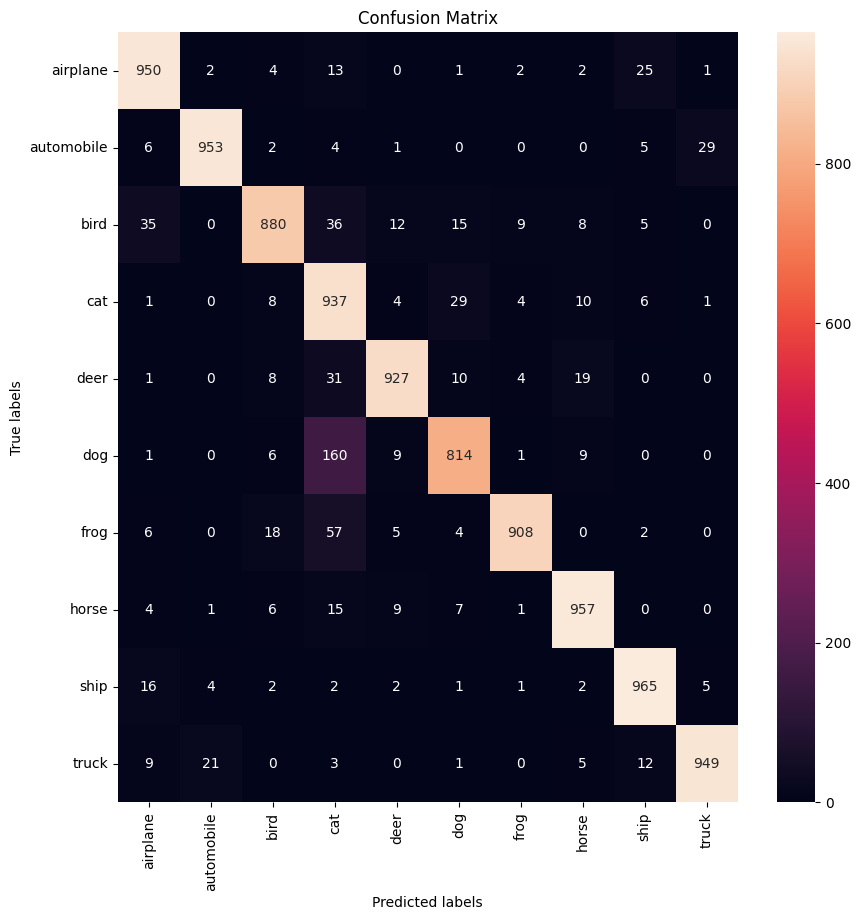

In [65]:
trainer.run(train_loader, max_epochs=30)

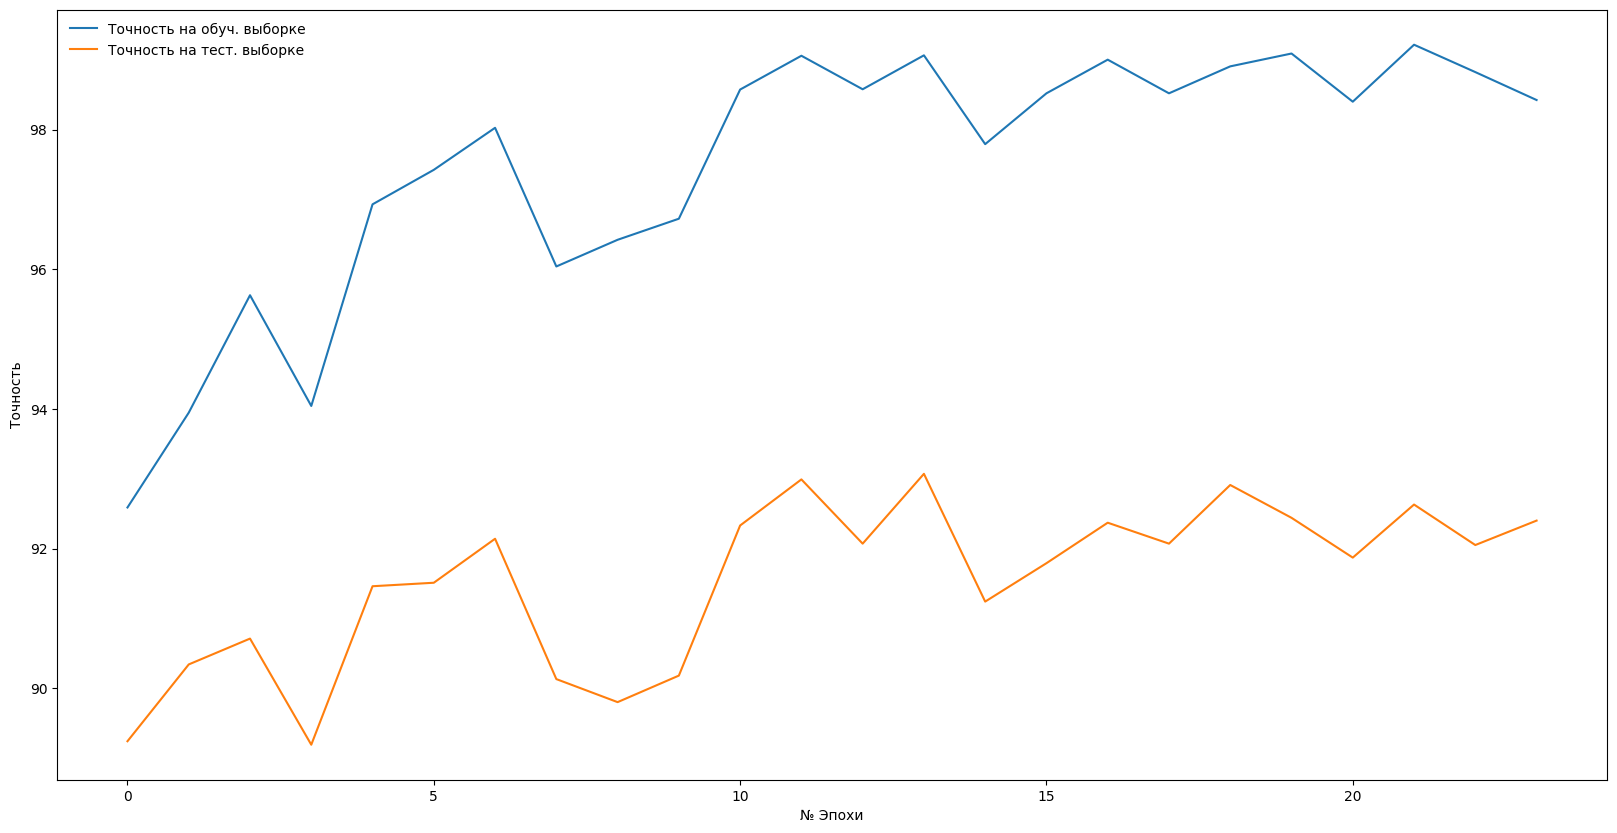

In [66]:
plt.rcParams["figure.figsize"] = (20,10)
plt.plot(training_history['accuracy'],label="Точность на обуч. выборке")
plt.plot(test_history['accuracy'],label="Точность на тест. выборке")
plt.xlabel('№ Эпохи')
plt.ylabel('Точность')
plt.legend(frameon=False)
plt.show()

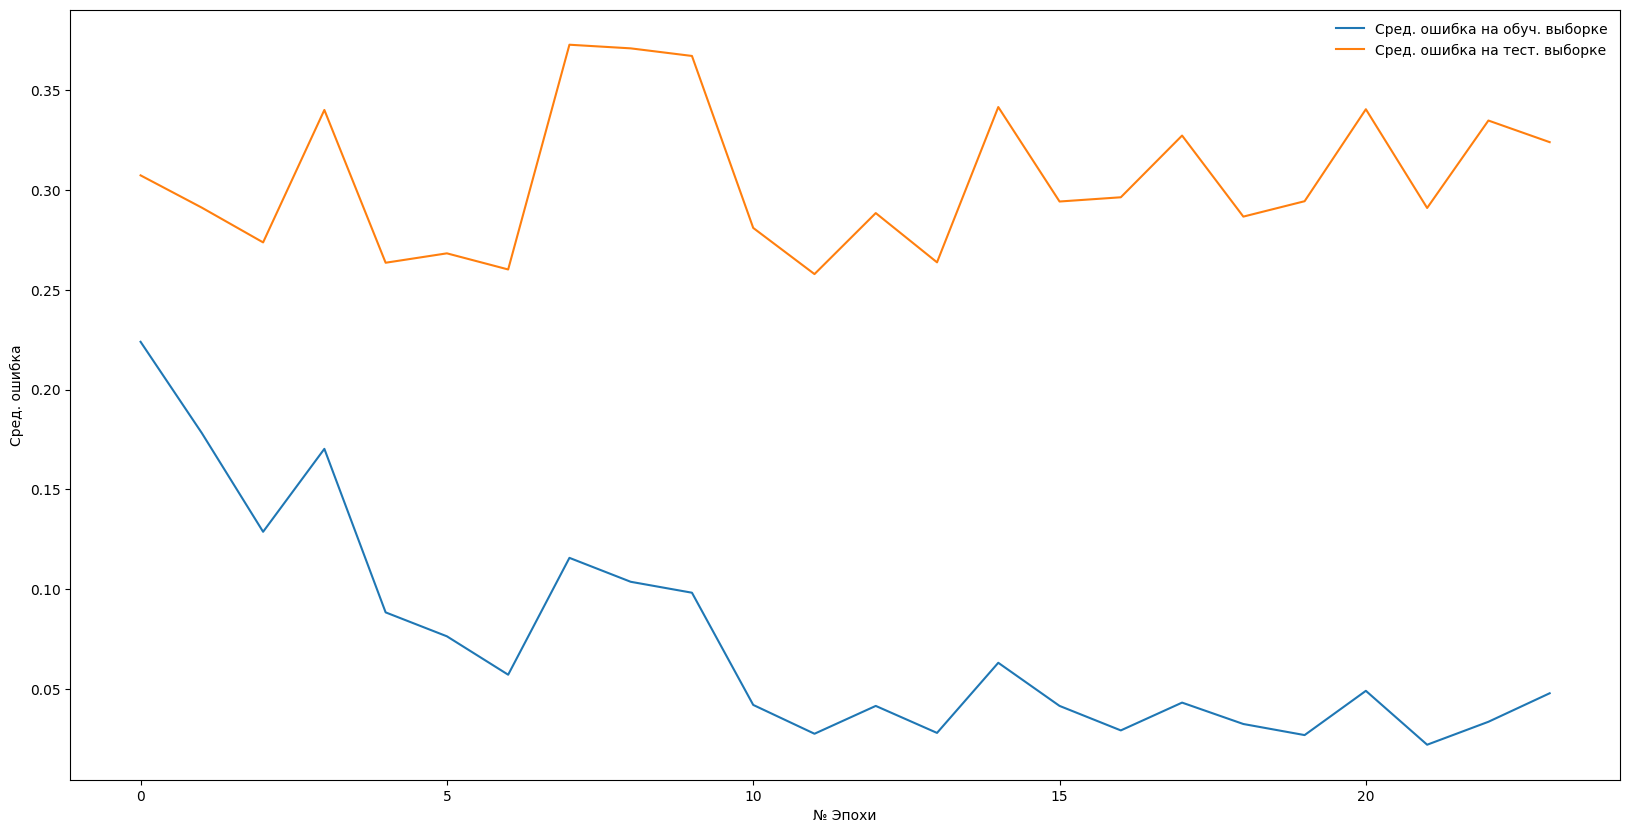

In [67]:
plt.rcParams["figure.figsize"] = (20,10)
plt.plot(training_history['loss'],label="Сред. ошибка на обуч. выборке")
plt.plot(test_history['loss'],label="Сред. ошибка на тест. выборке")
plt.xlabel('№ Эпохи')
plt.ylabel('Сред. ошибка')
plt.legend(frameon=False)
plt.show()

In [68]:
def fetch_last_checkpoint_model_filename(model_save_path):
    import os
    checkpoint_files = os.listdir(model_save_path)
    checkpoint_files = [f for f in checkpoint_files if '.pt' in f]
    checkpoint_iter = [
        int(x.split('_')[2].split('.')[0])
        for x in checkpoint_files]
    last_idx = np.array(checkpoint_iter).argmax()
    return os.path.join(model_save_path, checkpoint_files[last_idx])

model.load_state_dict(torch.load(fetch_last_checkpoint_model_filename('/content/models')))
print("Модель загружена")

Модель загружена


In [69]:
preds=[]
trgts=[]
with torch.no_grad():
  for data in tqdm(test_loader):
    inputs, targets=data[0].to(device),data[1].to(device)
    outputs=model(inputs)
    targets=targets.to('cpu').numpy()
    pred = outputs.data.max(1, keepdim=True)[1]
    pred = pred.to('cpu').numpy()
    trgts.append(targets)
    preds.append(pred)

  0%|          | 0/79 [00:00<?, ?it/s]

In [70]:
targets=[x for sub in trgts for x in sub]
predictions=[x[0] for sub in preds for x in sub]
targets=np.array(targets)
predictions=np.array(predictions)

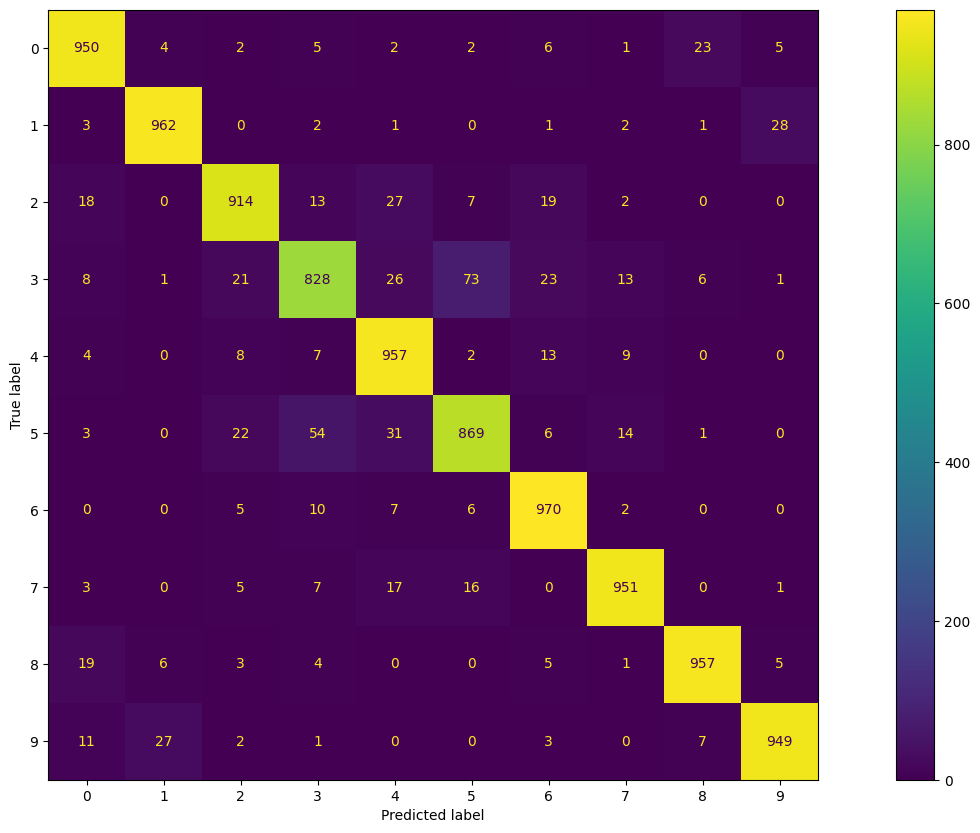

In [71]:
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay, f1_score
cm = confusion_matrix(targets, predictions)
ConfusionMatrixDisplay(cm).plot()

In [72]:
f1_score(targets, predictions,average='micro')

0.9307